## Compute rolling correlations of the assets

In this notebook, we'll
- compute the rolling correlations for the assets we've prepared in the previous notebook.
- compute the eigenvalues for each point in time and visualize them together with some interesting points in time


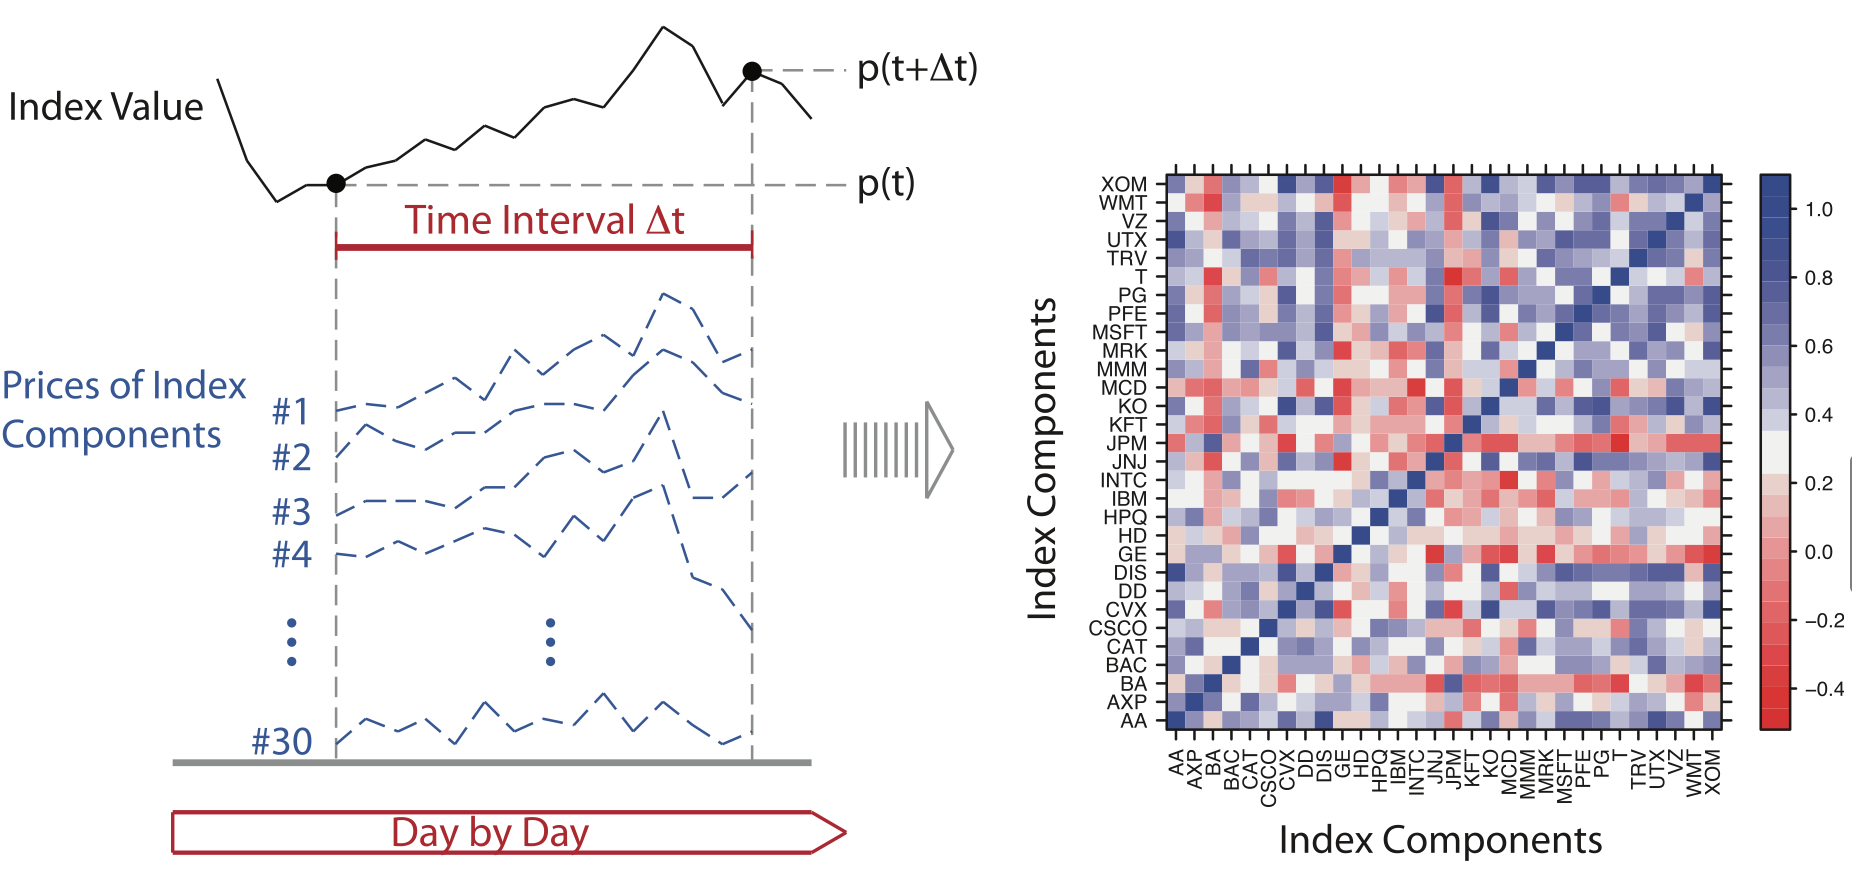

In [1]:
from IPython.core.display import Image 
Image(filename='scheme_correlation_computing.png') 

In [2]:
%load_ext autoreload
%autoreload 2

_viz_ is the module I've built for loading large sequences of correlation matrices from an HDFStore

In [12]:
import viz

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [13]:
sds = viz.StocksSource('dax30.h5', 'stx')
stx = sds.select('stx')

In [14]:
import pandas as pd
import pandas.io.data as web
import datetime
import pandas.io.pytables
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [15]:
with pandas.io.pytables.get_store('dax30.h5') as store:
    print store #.remove('x')

<class 'pandas.io.pytables.HDFStore'>
File path: dax30.h5
/dax            frame_table  (typ->appendable,nrows->28,ncols->7,indexers->[index])                   
/stx            wide_table   (typ->appendable,nrows->97937,ncols->7,indexers->[major_axis,minor_axis])


### Compute the rolling correlations 

The naive method works for this example, it could however blow your memory if the number of assets is higher.

In [16]:
corr = pd.rolling_corr( stx.Returns, 50, min_periods=30 )

### Compute the correlations stock-wise.


It makes it scaleable, which comes in handy when you have a large number of stocks.

In [17]:
number_days = 50
min_periods = number_days-20

def compute_corr(returns, stock, window=number_days, min_periods=min_periods):
    x = pd.stats.moments.rolling_corr( returns, returns[stock], window=window, min_periods=min_periods)
    x.reset_index(inplace=True)
    x['stock'] = stock
    x.set_index( ['index', 'stock'], inplace=True)
    return x.to_panel()

In [18]:
%%time

corr_hd5_path = 'corr2'
try:
    with pandas.io.pytables.get_store('dax30.h5') as store:
        store.remove(corr_hd5_path)
except:
    pass
    
for i, s in enumerate(stx.minor_axis.unique()):
    x = compute_corr( stx.Returns, s)
    with pandas.io.pytables.get_store('dax30.h5') as store:
        store.append( corr_hd5_path, x, min_itemsize = 7, format='t')

CPU times: user 3.71 s, sys: 131 ms, total: 3.84 s
Wall time: 3.83 s


In [19]:
#test that it is there and searchable
with pandas.io.pytables.get_store('dax30.h5') as store:
    aaaaa = store.select('corr2', pd.Term('major_axis', ">=", pd.Timestamp('20131201')))
    print aaaaa

<class 'pandas.core.panel.Panel'>
Dimensions: 28 (items) x 23 (major_axis) x 28 (minor_axis)
Items axis: ADS.DE to VOW3.DE
Major_axis axis: 2013-12-02 00:00:00 to 2014-01-01 00:00:00
Minor_axis axis: ADS.DE to VOW3.DE


In [20]:
%%time
# test access to 
ds = viz.CorrelationMatrixSource('dax30.h5', 'corr2')
for t, df in ds.iterate_time():
    if pd.Timestamp(t).year > 2002: break

CPU times: user 14.7 s, sys: 405 ms, total: 15.1 s
Wall time: 14.5 s


## PCA decomposition of the correlation matrices

In [21]:
from sklearn.decomposition import PCA

number_components = 5

def get_first_eigenvalues(mat, n_components=5):
    m = mat.values
    pca = PCA(n_components=n_components, whiten=False)
    pca.fit(m)
    return pca.explained_variance_, pca

In [22]:
aaaaa

<class 'pandas.core.panel.Panel'>
Dimensions: 28 (items) x 23 (major_axis) x 28 (minor_axis)
Items axis: ADS.DE to VOW3.DE
Major_axis axis: 2013-12-02 00:00:00 to 2014-01-01 00:00:00
Minor_axis axis: ADS.DE to VOW3.DE

In [23]:
_var, pca = get_first_eigenvalues(aaaaa.loc[:, pd.Timestamp('20131202'), :])

### Compute the first eigenvalues per time sample and how much of the variance they explain

In [24]:
# initialize DataFrame
all_t = ds.time_axis()
explained = pd.DataFrame(columns=map(str,range(1,number_components+1)), index=all_t)

# iterate
for t, df in ds.iterate_time():
    if df.shape[1] < 20: print t, df; continue
    try:
        _var, pca = get_first_eigenvalues(df)
        explained.loc[t] = _var
    except ValueError as e:
        print "skipping ", t

skipping  2003-02-12T00:00:00.000000000+0000


In [26]:
def plot_eigenvalues_over_time(explained):
    ax = explained.plot(figsize=(18,7))
    lim = plt.ylim()

    
    # Dotcom bubble
    ax.fill_between((pd.Timestamp('20000310'), pd.Timestamp('20000910')), lim[0], lim[1], alpha=0.1, facecolor='green')

    
    # Lehmann Brothers
    ax.fill_between((pd.Timestamp('20080801'), pd.Timestamp('20081001')), lim[0], lim[1], alpha=0.2, facecolor='green')

    # 9/11
    ax.fill_between((pd.Timestamp('20010911'), pd.Timestamp('20011011')), lim[0], lim[1], alpha=0.2, facecolor='blue')

    # 05/08/11	US down grade and European Debt Crisis 2011
    ax.fill_between((pd.Timestamp('20110805'), pd.Timestamp('20110905')), lim[0], lim[1], alpha=0.2, facecolor='blue')


    # 16/03/11	Fukushima melt down 2011
    ax.fill_between((pd.Timestamp('20110316'), pd.Timestamp('20110416')), lim[0], lim[1], alpha=0.2, facecolor='red')

    # 01/08/03	US Housing Bubble 2003
    ax.fill_between((pd.Timestamp('20030108'), pd.Timestamp('20030208')), lim[0], lim[1], alpha=0.2, facecolor='grey')

    # 06/09/12	EZB IR Event 2012
    ax.fill_between((pd.Timestamp('20120910'), pd.Timestamp('20121010')), lim[0], lim[1], alpha=0.2, facecolor='pink')
    ax.axis('tight')
    plt.ylabel('Explained variance')
    plt.savefig('eigenvalues.pdf', bbox='tight')

### Show the correlation-matrix eigenvalues and some very important events

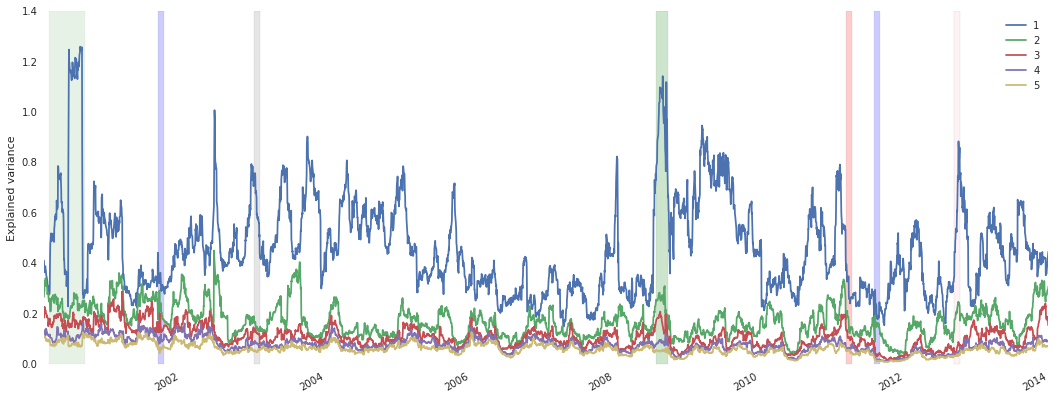

In [27]:
plot_eigenvalues_over_time(explained)